In [1]:
#Package import
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Any, Callable

# Progress bar
from tqdm import tqdm
from zipfile import ZipFile



# Scikit Learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# PyTorch & torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Helpers file
import helpers

# 5. Data pre-processing

In [2]:
IMPORT_INTERP = True

if IMPORT_INTERP :
    df_X_train = pd.read_csv("project-data-interpolated-corrected/df_X_train.csv", index_col=0)
    df_X_test = pd.read_csv("project-data-interpolated-corrected/df_X_test.csv", index_col=0)
    df_X_val = pd.read_csv("project-data-interpolated-corrected/df_X_val.csv", index_col=0)
    df_y_train = pd.read_csv("project-data-interpolated-corrected/df_y_train.csv", index_col=0)
    df_y_val = pd.read_csv("project-data-interpolated-corrected/df_y_val.csv", index_col=0)

In [3]:
DROP = True 

if DROP :
    cols =['magnitude', 'distance_closest', 'lowest_usable_frequency']
    df_X_train.drop(columns=cols, inplace=True)
    df_X_val.drop(columns=cols, inplace=True)
    df_X_test.drop(columns=cols, inplace=True)

### 5.1 Boolean to numerical conversion

In [4]:
df_X_train = helpers.bool_to_num(df_X_train)
df_X_val = helpers.bool_to_num(df_X_val)
df_X_test = helpers.bool_to_num(df_X_test)

In [5]:
if IMPORT_INTERP:
    df_y_train = helpers.bool_to_num(df_y_train)
    df_y_val = helpers.bool_to_num(df_y_val)
    
if not(IMPORT_INTERP):   
    df_y_train = helpers.bool_to_num(pd.DataFrame(df_y_train))
    df_y_val = helpers.bool_to_num(pd.DataFrame(df_y_val))

### 5.2 Pandas to Numpy conversion

In [6]:
X_train = helpers.numpy_converter(df_X_train)
X_val = helpers.numpy_converter(df_X_val)
X_test = helpers.numpy_converter(df_X_test)

y_train_final = helpers.numpy_converter(df_y_train)
y_val_final = helpers.numpy_converter(df_y_val)

### 5.3 Normalization

In [7]:
sc = StandardScaler()
sc.fit(X_train)
X_train_final = sc.transform(X_train)
X_val_final = sc.transform(X_val)
X_test_final = sc.transform(X_test)

### 5.4 Principal Component Analysis

Fit and tranform the data to reduce the number of features (`features` to `PC`)

#### PCA with all the features and without the -999 rows

#### PCA with the Sa(t) and without the columns contained -999

# 6. Machine Learning Models

## Neural Network

### 6.1 Define the hyperparameters

In [8]:
#number times that the learning algorithm will work through the entire training dataset
epochs = 15   

#number of samples to work through before updating the internal model parameters
batch_size =128  #if 64 slower but similar results

#
lr = 0.01 

#
weight_decay = 1e-5 #if 1e-1 less overfitting and curves loss are closer but worst results

#
batch_norm_momentum = 0.1 #not good if bigger


#randomly zeroes some of the elements of the input tensor during training with probability=dropout using a Bernoulli distribution
dropout=0.1    #small is better 

#
coef_sheduler = 0.60 #0.60 best results, if increased -->  training accuracy above 0.83 but increases overfitting so worst final result

### 6.2 Data as a PyTorch Dataset class

#### Define the Dataset class for each dataset

In [9]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data): #for initialization operations (reading and preprocess data)
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):  #returns data in batches
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [10]:
class ValData(Dataset):
    def __init__(self, X_data, y_data): #for initialization operations (reading and preprocess data)
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):  #returns data in batches
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [11]:
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

#### Create the data classes

In [12]:
train_data = TrainData(torch.FloatTensor(X_train_final), torch.FloatTensor(y_train_final))
val_data = ValData(torch.FloatTensor(X_val_final), torch.FloatTensor(y_val_final))
test_data = TestData(torch.FloatTensor(X_test_final))

#### Load the data as DataLoader class

To be able to use mini-batch for the gradient descent, the data must be configured with the DataLoader \
The `batch_size` is defined as a hyperparameter at the beginning of the section

In [13]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=X_val_final.shape[0], shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

### 6.3 Model Setup

#### 6.3.1 The Model

#### Define the model class

In [14]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.l1 = nn.Linear(X_train_final.shape[1], 80)
        self.bnm1 = nn.BatchNorm1d(80, momentum=batch_norm_momentum)
        self.l2 = nn.Linear(80, 30)
        self.bnm2 = nn.BatchNorm1d(30, momentum=batch_norm_momentum)
        self.l3 = nn.Linear(30, 20)
        self.bnm3 = nn.BatchNorm1d(20, momentum=batch_norm_momentum)
        self.l4 = nn.Linear(20, 1)
       
        
        self.dropout = nn.Dropout(dropout)
        
        self.Relu = nn.ReLU()
        
        self.initialize_weights()

    def forward(self, x):
        x = self.Relu(self.l1(x))
        x = self.dropout(x)
        x = self.bnm1(x)
        x = self.Relu(self.l2(x))
        x = self.dropout(x)
        x = self.bnm2(x)
        x = self.Relu(self.l3(x))
        x = self.dropout(x)
        x = self.bnm3(x)
        y_pred = self.l4(x)
        return y_pred
    
    def initialize_weights(self):  
        for m in self.modules():
            if isinstance(m,nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias,0)

#### Create the model from the class

In [15]:
model = Model()

Use the GPU if available otherwise the CPU

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Move model on the GPU if active

In [17]:
model.to(device)

Model(
  (l1): Linear(in_features=112, out_features=80, bias=True)
  (bnm1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2): Linear(in_features=80, out_features=30, bias=True)
  (bnm2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l3): Linear(in_features=30, out_features=20, bias=True)
  (bnm3): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l4): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (Relu): ReLU()
)

#### 6.3.2 Specify the optimizer 

Write about Adam optimizer, maybe add few formulas to describe or idk

In [18]:
optimizer = optim.Adam(model.parameters(), lr=lr , weight_decay=weight_decay)

#### 6.3.3 Specify the loss function

write also about this loss function

In [19]:
criterion = nn.BCEWithLogitsLoss()

#### 6.3.4 Adjust learning rate

explain chosen scheduler etc 

In [20]:
lambda_scheduler = lambda epoch: coef_sheduler ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_scheduler)


#### 6.3.4 Accuracy calculation

In [21]:
def b_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = acc * 100
    
    return acc

### 6.4 Training

#### Create a function to train the model and validate it at each epoch

In [22]:
def train(model: torch.nn.Module, train_loader: torch.utils.data.DataLoader, val_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, epochs: int):
    accs_train = []
    losses_train = []
    accs_val = []
    losses_val = []
    
    for e in range(1, epochs+1):
        epoch_loss_train = 0
        epoch_acc_train = 0
        epoch_loss_val = 0
        epoch_acc_val = 0
        
        #TRAINING LOOP FOR EACH EPOCH
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch)
            acc_train = b_acc(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()

            epoch_loss_train += loss.item()
            epoch_acc_train += acc_train.item()
            
        scheduler.step()
        
        losses_train.append(epoch_loss_train/len(train_loader))
        accs_train.append(epoch_acc_train/len(train_loader))
        
    
        #VALIDATION LOOP FOR EACH EPOCH
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                y_val_pred = model(X_batch)

                loss_val = criterion(y_val_pred, y_batch)
                acc_val = b_acc(y_val_pred, y_batch)

                epoch_loss_val += loss_val.item()
                epoch_acc_val += acc_val.item()

            losses_val.append(epoch_loss_val/len(val_loader))
            accs_val.append(epoch_acc_val/len(val_loader))          
        
        print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss_train/len(train_loader):.5f} | Val Loss: {epoch_loss_val/len(val_loader):.5f} | Train Acc: {epoch_acc_train/len(train_loader):.3f} | Val Acc: {epoch_acc_val/len(val_loader):.3f}')
    return losses_train, accs_train, losses_val, accs_val

#### Train the model

In [23]:
loss_train, acc_train, loss_val, acc_val =  train(model, train_loader, val_loader, criterion, optimizer, epochs)

Epoch 001: | Train Loss: 0.41710 | Val Loss: 0.39451 | Train Acc: 80.435 | Val Acc: 80.295
Epoch 002: | Train Loss: 0.39326 | Val Loss: 0.38319 | Train Acc: 81.328 | Val Acc: 80.533
Epoch 003: | Train Loss: 0.38707 | Val Loss: 0.38989 | Train Acc: 81.765 | Val Acc: 80.295
Epoch 004: | Train Loss: 0.38153 | Val Loss: 0.38350 | Train Acc: 82.011 | Val Acc: 80.971
Epoch 005: | Train Loss: 0.37866 | Val Loss: 0.38521 | Train Acc: 82.270 | Val Acc: 80.892
Epoch 006: | Train Loss: 0.37629 | Val Loss: 0.37902 | Train Acc: 82.340 | Val Acc: 81.369
Epoch 007: | Train Loss: 0.37359 | Val Loss: 0.38649 | Train Acc: 82.508 | Val Acc: 81.330
Epoch 008: | Train Loss: 0.37254 | Val Loss: 0.38223 | Train Acc: 82.575 | Val Acc: 81.568
Epoch 009: | Train Loss: 0.37206 | Val Loss: 0.37722 | Train Acc: 82.592 | Val Acc: 81.250
Epoch 010: | Train Loss: 0.37168 | Val Loss: 0.38713 | Train Acc: 82.590 | Val Acc: 81.290
Epoch 011: | Train Loss: 0.37146 | Val Loss: 0.38116 | Train Acc: 82.544 | Val Acc: 81.768

### 6.5 Validation

Plot the evolution of the loss and the accuracy with the epoch

Text(0, 0.5, 'Accuracy')

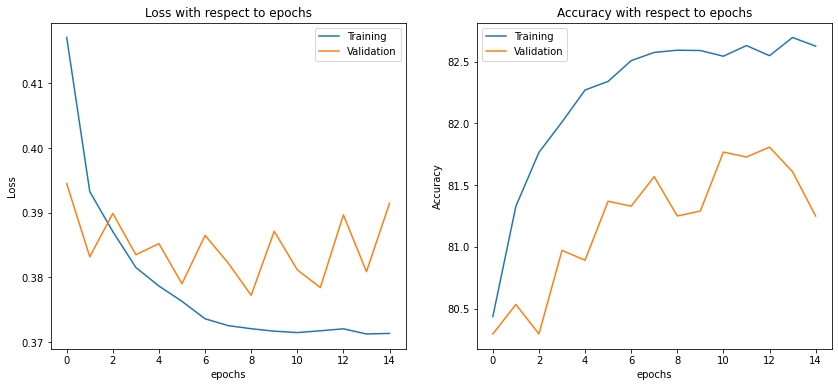

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

ax[0].set_title('Loss with respect to epochs')
ax[0].plot(loss_train)
ax[0].plot(loss_val)
ax[0].legend(['Training', 'Validation'])
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')

ax[1].set_title('Accuracy with respect to epochs')
ax[1].plot(acc_train)
ax[1].plot(acc_val)
ax[1].legend(['Training', 'Validation'])
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')

In [25]:
%%html
<style>
table {float:left}
</style>

In [26]:
#Settings for the plots 
sns.set_style("ticks")
colors= sns.color_palette('colorblind')
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=13)
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.minor.size'] = 6

sns.set_style("darkgrid", {'axes.grid' : False, 'ytick.left': True, 'xtick.bottom': True})

# 5. Data pre-processing

In [27]:
IMPORT_INTERP = True

if IMPORT_INTERP :
    df_X_train = pd.read_csv("project-data-interpolated-corrected/df_X_train.csv", index_col=0)
    df_X_test = pd.read_csv("project-data-interpolated-corrected/df_X_test.csv", index_col=0)
    df_X_val = pd.read_csv("project-data-interpolated-corrected/df_X_val.csv", index_col=0)
    df_y_train = pd.read_csv("project-data-interpolated-corrected/df_y_train.csv", index_col=0)
    df_y_val = pd.read_csv("project-data-interpolated-corrected/df_y_val.csv", index_col=0)

In [28]:
DROP = False 

if DROP :
    cols =['magnitude', 'distance_closest', 'lowest_usable_frequency']
    df_X_train.drop(columns=cols, inplace=True)
    df_X_val.drop(columns=cols, inplace=True)
    df_X_test.drop(columns=cols, inplace=True)

### 5.1 Boolean to numerical conversion

In [29]:
df_X_train = helpers.bool_to_num(df_X_train)
df_X_val = helpers.bool_to_num(df_X_val)
df_X_test = helpers.bool_to_num(df_X_test)

In [30]:
if IMPORT_INTERP:
    df_y_train = helpers.bool_to_num(df_y_train)
    df_y_val = helpers.bool_to_num(df_y_val)
    
if not(IMPORT_INTERP):   
    df_y_train = helpers.bool_to_num(pd.DataFrame(df_y_train))
    df_y_val = helpers.bool_to_num(pd.DataFrame(df_y_val))

### 5.2 Pandas to Numpy conversion

In [31]:
X_train = helpers.numpy_converter(df_X_train)
X_val = helpers.numpy_converter(df_X_val)
X_test = helpers.numpy_converter(df_X_test)

y_train_final = helpers.numpy_converter(df_y_train)
y_val_final = helpers.numpy_converter(df_y_val)

### 5.3 Normalization

In [32]:
sc = StandardScaler()
sc.fit(X_train)
X_train_final = sc.transform(X_train)
X_val_final = sc.transform(X_val)
X_test_final = sc.transform(X_test)

### 5.4 Principal Component Analysis

Fit and tranform the data to reduce the number of features (`features` to `PC`)

#### PCA with all the features and without the -999 rows

#### PCA with the Sa(t) and without the columns contained -999

# 6. Machine Learning Models

## Neural Network

### 6.1 Define the hyperparameters

In [33]:
#number times that the learning algorithm will work through the entire training dataset
epochs = 30     

#number of samples to work through before updating the internal model parameters
batch_size =128  #if 64 slower but similar results

#
lr = 0.01 

#
weight_decay = 1e-5 #if 1e-1 less overfitting and curves loss are closer but worst results

#
batch_norm_momentum = 0.1 #not good if bigger


#randomly zeroes some of the elements of the input tensor during training with probability=dropout using a Bernoulli distribution
dropout=0.1    #small is better 

#
coef_sheduler = 0.60 #0.60 best results, if increased -->  training accuracy above 0.83 but increases overfitting so worst final result

### 6.2 Data as a PyTorch Dataset class

#### Define the Dataset class for each dataset

In [34]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data): #for initialization operations (reading and preprocess data)
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):  #returns data in batches
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [35]:
class ValData(Dataset):
    def __init__(self, X_data, y_data): #for initialization operations (reading and preprocess data)
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):  #returns data in batches
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [36]:
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

#### Create the data classes

In [37]:
train_data = TrainData(torch.FloatTensor(X_train_final), torch.FloatTensor(y_train_final))
val_data = ValData(torch.FloatTensor(X_val_final), torch.FloatTensor(y_val_final))
test_data = TestData(torch.FloatTensor(X_test_final))

#### Load the data as DataLoader class

To be able to use mini-batch for the gradient descent, the data must be configured with the DataLoader \
The `batch_size` is defined as a hyperparameter at the beginning of the section

In [38]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=X_val_final.shape[0], shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

### 6.3 Model Setup

#### 6.3.1 The Model

#### Define the model class

In [39]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.l1 = nn.Linear(X_train_final.shape[1], 80)
        self.bnm1 = nn.BatchNorm1d(80, momentum=batch_norm_momentum)
        self.l2 = nn.Linear(80, 30)
        self.bnm2 = nn.BatchNorm1d(30, momentum=batch_norm_momentum)
        self.l3 = nn.Linear(30, 20)
        self.bnm3 = nn.BatchNorm1d(20, momentum=batch_norm_momentum)
        self.l4 = nn.Linear(20, 1)
       
        
        self.dropout = nn.Dropout(dropout)
        
        self.Relu = nn.ReLU()
        
        self.initialize_weights()

    def forward(self, x):
        x = self.Relu(self.l1(x))
        x = self.dropout(x)
        x = self.bnm1(x)
        x = self.Relu(self.l2(x))
        x = self.dropout(x)
        x = self.bnm2(x)
        x = self.Relu(self.l3(x))
        x = self.dropout(x)
        x = self.bnm3(x)
        y_pred = self.l4(x)
        return y_pred
    
    def initialize_weights(self):  
        for m in self.modules():
            if isinstance(m,nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias,0)

#### Create the model from the class

In [40]:
model = Model()

Use the GPU if available otherwise the CPU

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Move model on the GPU if active

In [42]:
model.to(device)

Model(
  (l1): Linear(in_features=115, out_features=80, bias=True)
  (bnm1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2): Linear(in_features=80, out_features=30, bias=True)
  (bnm2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l3): Linear(in_features=30, out_features=20, bias=True)
  (bnm3): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l4): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (Relu): ReLU()
)

#### 6.3.2 Specify the optimizer 

Write about Adam optimizer, maybe add few formulas to describe or idk

In [43]:
optimizer = optim.Adam(model.parameters(), lr=lr , weight_decay=weight_decay)

#### 6.3.3 Specify the loss function

write also about this loss function

In [44]:
criterion = nn.BCEWithLogitsLoss()

#### 6.3.4 Adjust learning rate

explain chosen scheduler etc 

In [45]:
lambda_scheduler = lambda epoch: coef_sheduler ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_scheduler)


#### 6.3.4 Accuracy calculation

In [46]:
def b_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = acc * 100
    
    return acc

### 6.4 Training

#### Create a function to train the model and validate it at each epoch

In [47]:
def train(model: torch.nn.Module, train_loader: torch.utils.data.DataLoader, val_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, epochs: int):
    accs_train = []
    losses_train = []
    accs_val = []
    losses_val = []
    
    for e in range(1, epochs+1):
        epoch_loss_train = 0
        epoch_acc_train = 0
        epoch_loss_val = 0
        epoch_acc_val = 0
        
        #TRAINING LOOP FOR EACH EPOCH
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch)
            acc_train = b_acc(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()

            epoch_loss_train += loss.item()
            epoch_acc_train += acc_train.item()
            
        scheduler.step()
        
        losses_train.append(epoch_loss_train/len(train_loader))
        accs_train.append(epoch_acc_train/len(train_loader))
        
    
        #VALIDATION LOOP FOR EACH EPOCH
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                y_val_pred = model(X_batch)

                loss_val = criterion(y_val_pred, y_batch)
                acc_val = b_acc(y_val_pred, y_batch)

                epoch_loss_val += loss_val.item()
                epoch_acc_val += acc_val.item()

            losses_val.append(epoch_loss_val/len(val_loader))
            accs_val.append(epoch_acc_val/len(val_loader))          
        
        print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss_train/len(train_loader):.5f} | Val Loss: {epoch_loss_val/len(val_loader):.5f} | Train Acc: {epoch_acc_train/len(train_loader):.3f} | Val Acc: {epoch_acc_val/len(val_loader):.3f}')
    return losses_train, accs_train, losses_val, accs_val

#### Train the model

In [48]:
loss_train, acc_train, loss_val, acc_val =  train(model, train_loader, val_loader, criterion, optimizer, epochs)

Epoch 001: | Train Loss: 0.41093 | Val Loss: 0.38578 | Train Acc: 80.518 | Val Acc: 80.812
Epoch 002: | Train Loss: 0.38703 | Val Loss: 0.38218 | Train Acc: 81.673 | Val Acc: 81.250
Epoch 003: | Train Loss: 0.37823 | Val Loss: 0.37774 | Train Acc: 82.030 | Val Acc: 81.210
Epoch 004: | Train Loss: 0.37271 | Val Loss: 0.37193 | Train Acc: 82.234 | Val Acc: 81.449
Epoch 005: | Train Loss: 0.36748 | Val Loss: 0.37111 | Train Acc: 82.484 | Val Acc: 81.449
Epoch 006: | Train Loss: 0.36583 | Val Loss: 0.37493 | Train Acc: 82.716 | Val Acc: 81.489
Epoch 007: | Train Loss: 0.36315 | Val Loss: 0.36987 | Train Acc: 82.941 | Val Acc: 80.971
Epoch 008: | Train Loss: 0.36257 | Val Loss: 0.36633 | Train Acc: 82.863 | Val Acc: 81.250
Epoch 009: | Train Loss: 0.36156 | Val Loss: 0.37226 | Train Acc: 82.933 | Val Acc: 80.932
Epoch 010: | Train Loss: 0.36028 | Val Loss: 0.37165 | Train Acc: 82.976 | Val Acc: 81.091
Epoch 011: | Train Loss: 0.35980 | Val Loss: 0.36310 | Train Acc: 82.986 | Val Acc: 81.330

### 6.5 Validation

Plot the evolution of the loss and the accuracy with the epoch

Text(0, 0.5, 'Accuracy')

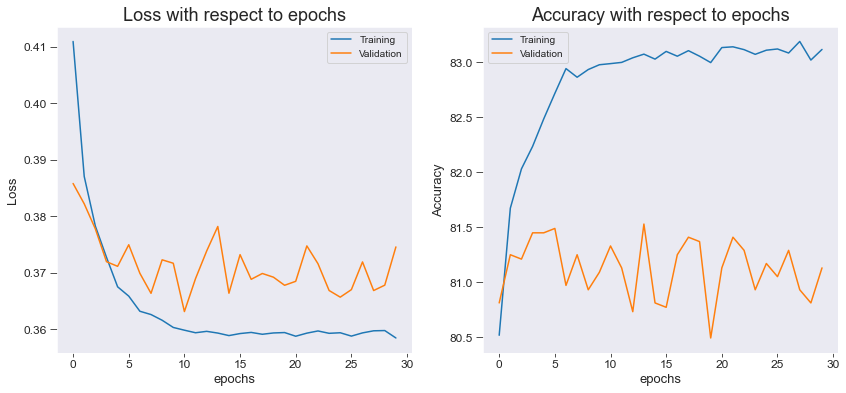

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

ax[0].set_title('Loss with respect to epochs')
ax[0].plot(loss_train)
ax[0].plot(loss_val)
ax[0].legend(['Training', 'Validation'])
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')

ax[1].set_title('Accuracy with respect to epochs')
ax[1].plot(acc_train)
ax[1].plot(acc_val)
ax[1].legend(['Training', 'Validation'])
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')

# 5. Data pre-processing

In [50]:
IMPORT_INTERP = True

if IMPORT_INTERP :
    df_X_train = pd.read_csv("project-data-interpolated-corrected/df_X_train.csv", index_col=0)
    df_X_test = pd.read_csv("project-data-interpolated-corrected/df_X_test.csv", index_col=0)
    df_X_val = pd.read_csv("project-data-interpolated-corrected/df_X_val.csv", index_col=0)
    df_y_train = pd.read_csv("project-data-interpolated-corrected/df_y_train.csv", index_col=0)
    df_y_val = pd.read_csv("project-data-interpolated-corrected/df_y_val.csv", index_col=0)

In [51]:
DROP = True 

if DROP :
    cols =['magnitude', 'distance_closest', 'lowest_usable_frequency']
    df_X_train.drop(columns=cols, inplace=True)
    df_X_val.drop(columns=cols, inplace=True)
    df_X_test.drop(columns=cols, inplace=True)

### 5.1 Boolean to numerical conversion

In [52]:
df_X_train = helpers.bool_to_num(df_X_train)
df_X_val = helpers.bool_to_num(df_X_val)
df_X_test = helpers.bool_to_num(df_X_test)

In [53]:
if IMPORT_INTERP:
    df_y_train = helpers.bool_to_num(df_y_train)
    df_y_val = helpers.bool_to_num(df_y_val)
    
if not(IMPORT_INTERP):   
    df_y_train = helpers.bool_to_num(pd.DataFrame(df_y_train))
    df_y_val = helpers.bool_to_num(pd.DataFrame(df_y_val))

### 5.2 Pandas to Numpy conversion

In [54]:
X_train = helpers.numpy_converter(df_X_train)
X_val = helpers.numpy_converter(df_X_val)
X_test = helpers.numpy_converter(df_X_test)

y_train_final = helpers.numpy_converter(df_y_train)
y_val_final = helpers.numpy_converter(df_y_val)

### 5.3 Normalization

In [55]:
sc = StandardScaler()
sc.fit(X_train)
X_train_final = sc.transform(X_train)
X_val_final = sc.transform(X_val)
X_test_final = sc.transform(X_test)

### 5.4 Principal Component Analysis

Fit and tranform the data to reduce the number of features (`features` to `PC`)

#### PCA with all the features and without the -999 rows

#### PCA with the Sa(t) and without the columns contained -999

# 6. Machine Learning Models

## Neural Network

### 6.1 Define the hyperparameters

In [56]:
#number times that the learning algorithm will work through the entire training dataset
epochs = 30     

#number of samples to work through before updating the internal model parameters
batch_size =128  #if 64 slower but similar results

#
lr = 0.01 

#
weight_decay = 1e-5 #if 1e-1 less overfitting and curves loss are closer but worst results

#
batch_norm_momentum = 0.1 #not good if bigger


#randomly zeroes some of the elements of the input tensor during training with probability=dropout using a Bernoulli distribution
dropout=0.1    #small is better 

#
coef_sheduler = 0.60 #0.60 best results, if increased -->  training accuracy above 0.83 but increases overfitting so worst final result

### 6.2 Data as a PyTorch Dataset class

#### Define the Dataset class for each dataset

In [57]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data): #for initialization operations (reading and preprocess data)
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):  #returns data in batches
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [58]:
class ValData(Dataset):
    def __init__(self, X_data, y_data): #for initialization operations (reading and preprocess data)
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):  #returns data in batches
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [59]:
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

#### Create the data classes

In [60]:
train_data = TrainData(torch.FloatTensor(X_train_final), torch.FloatTensor(y_train_final))
val_data = ValData(torch.FloatTensor(X_val_final), torch.FloatTensor(y_val_final))
test_data = TestData(torch.FloatTensor(X_test_final))

#### Load the data as DataLoader class

To be able to use mini-batch for the gradient descent, the data must be configured with the DataLoader \
The `batch_size` is defined as a hyperparameter at the beginning of the section

In [61]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=X_val_final.shape[0], shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

### 6.3 Model Setup

#### 6.3.1 The Model

#### Define the model class

In [62]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.l1 = nn.Linear(X_train_final.shape[1], 80)
        self.bnm1 = nn.BatchNorm1d(80, momentum=batch_norm_momentum)
        self.l2 = nn.Linear(80, 30)
        self.bnm2 = nn.BatchNorm1d(30, momentum=batch_norm_momentum)
        self.l3 = nn.Linear(30, 20)
        self.bnm3 = nn.BatchNorm1d(20, momentum=batch_norm_momentum)
        self.l4 = nn.Linear(20, 1)
       
        
        self.dropout = nn.Dropout(dropout)
        
        self.Relu = nn.ReLU()
        
        self.initialize_weights()

    def forward(self, x):
        x = self.Relu(self.l1(x))
        x = self.dropout(x)
        x = self.bnm1(x)
        x = self.Relu(self.l2(x))
        x = self.dropout(x)
        x = self.bnm2(x)
        x = self.Relu(self.l3(x))
        x = self.dropout(x)
        x = self.bnm3(x)
        y_pred = self.l4(x)
        return y_pred
    
    def initialize_weights(self):  
        for m in self.modules():
            if isinstance(m,nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias,0)

#### Create the model from the class

In [63]:
model = Model()

Use the GPU if available otherwise the CPU

In [64]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Move model on the GPU if active

In [65]:
model.to(device)

Model(
  (l1): Linear(in_features=112, out_features=80, bias=True)
  (bnm1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2): Linear(in_features=80, out_features=30, bias=True)
  (bnm2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l3): Linear(in_features=30, out_features=20, bias=True)
  (bnm3): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l4): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (Relu): ReLU()
)

#### 6.3.2 Specify the optimizer 

Write about Adam optimizer, maybe add few formulas to describe or idk

In [66]:
optimizer = optim.Adam(model.parameters(), lr=lr , weight_decay=weight_decay)

#### 6.3.3 Specify the loss function

write also about this loss function

In [67]:
criterion = nn.BCEWithLogitsLoss()

#### 6.3.4 Adjust learning rate

explain chosen scheduler etc 

In [68]:
lambda_scheduler = lambda epoch: coef_sheduler ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_scheduler)


#### 6.3.4 Accuracy calculation

In [69]:
def b_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = acc * 100
    
    return acc

### 6.4 Training

#### Create a function to train the model and validate it at each epoch

In [70]:
def train(model: torch.nn.Module, train_loader: torch.utils.data.DataLoader, val_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, epochs: int):
    accs_train = []
    losses_train = []
    accs_val = []
    losses_val = []
    
    for e in range(1, epochs+1):
        epoch_loss_train = 0
        epoch_acc_train = 0
        epoch_loss_val = 0
        epoch_acc_val = 0
        
        #TRAINING LOOP FOR EACH EPOCH
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch)
            acc_train = b_acc(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()

            epoch_loss_train += loss.item()
            epoch_acc_train += acc_train.item()
            
        scheduler.step()
        
        losses_train.append(epoch_loss_train/len(train_loader))
        accs_train.append(epoch_acc_train/len(train_loader))
        
    
        #VALIDATION LOOP FOR EACH EPOCH
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                y_val_pred = model(X_batch)

                loss_val = criterion(y_val_pred, y_batch)
                acc_val = b_acc(y_val_pred, y_batch)

                epoch_loss_val += loss_val.item()
                epoch_acc_val += acc_val.item()

            losses_val.append(epoch_loss_val/len(val_loader))
            accs_val.append(epoch_acc_val/len(val_loader))          
        
        print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss_train/len(train_loader):.5f} | Val Loss: {epoch_loss_val/len(val_loader):.5f} | Train Acc: {epoch_acc_train/len(train_loader):.3f} | Val Acc: {epoch_acc_val/len(val_loader):.3f}')
    return losses_train, accs_train, losses_val, accs_val

#### Train the model

In [71]:
loss_train, acc_train, loss_val, acc_val =  train(model, train_loader, val_loader, criterion, optimizer, epochs)

Epoch 001: | Train Loss: 0.41613 | Val Loss: 0.40349 | Train Acc: 80.453 | Val Acc: 79.737
Epoch 002: | Train Loss: 0.39365 | Val Loss: 0.38435 | Train Acc: 81.433 | Val Acc: 81.489
Epoch 003: | Train Loss: 0.38682 | Val Loss: 0.39024 | Train Acc: 81.816 | Val Acc: 80.772
Epoch 004: | Train Loss: 0.38267 | Val Loss: 0.37605 | Train Acc: 81.971 | Val Acc: 80.732
Epoch 005: | Train Loss: 0.37886 | Val Loss: 0.38573 | Train Acc: 82.134 | Val Acc: 81.091
Epoch 006: | Train Loss: 0.37672 | Val Loss: 0.38122 | Train Acc: 82.282 | Val Acc: 80.414
Epoch 007: | Train Loss: 0.37413 | Val Loss: 0.38019 | Train Acc: 82.345 | Val Acc: 80.932
Epoch 008: | Train Loss: 0.37273 | Val Loss: 0.38612 | Train Acc: 82.488 | Val Acc: 80.693
Epoch 009: | Train Loss: 0.37222 | Val Loss: 0.38300 | Train Acc: 82.528 | Val Acc: 81.011
Epoch 010: | Train Loss: 0.37209 | Val Loss: 0.38055 | Train Acc: 82.532 | Val Acc: 81.250
Epoch 011: | Train Loss: 0.37103 | Val Loss: 0.38008 | Train Acc: 82.559 | Val Acc: 80.653

### 6.5 Validation

Plot the evolution of the loss and the accuracy with the epoch

Text(0, 0.5, 'Accuracy')

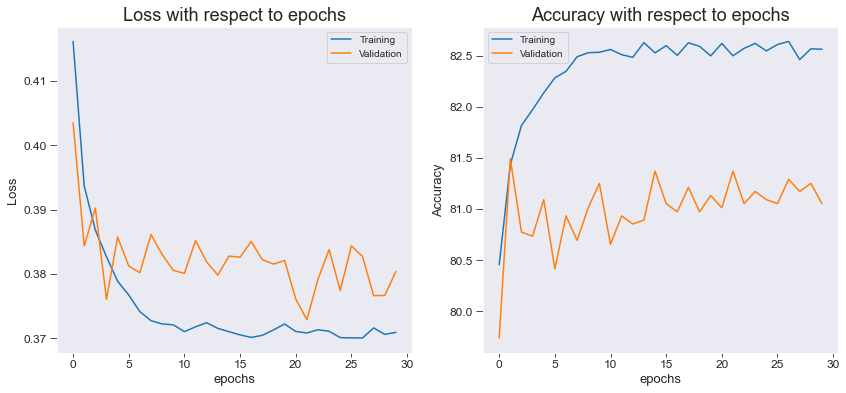

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

ax[0].set_title('Loss with respect to epochs')
ax[0].plot(loss_train)
ax[0].plot(loss_val)
ax[0].legend(['Training', 'Validation'])
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')

ax[1].set_title('Accuracy with respect to epochs')
ax[1].plot(acc_train)
ax[1].plot(acc_val)
ax[1].legend(['Training', 'Validation'])
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')